# Final project Group 19

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import spacy
import json

from datasets import load_dataset
from collections import Counter

from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from nltk.corpus.reader import ConllCorpusReader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

from simpletransformers.classification import ClassificationModel, ClassificationArgs

nltk.download('vader_lexicon')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/axelehrnrooth/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## 1. Named Entity recognition
For the entity recognition we used a fork of the ontonotes dataset
The dataset is split into tokens, and gets PoS tags added by NLTK

In [2]:
# 1. Load the ontonotes fork dataset
# 2. Read the JSON label files
# 3. Convert the dataframe into a (large) list of tokens with pos and entity labels

dataset = load_dataset("tner/ontonotes5")
ontonotes5_train_dataset = pd.DataFrame(dataset['train'])

with open('dataset_label.json', 'r') as file:
    labels = json.load(file)
    
labels_by_id = { v:k for k,v in labels.items() }
training_tokens = []

for row in ontonotes5_train_dataset.iterrows():
    zipped = list(zip(row[1]['tokens'], row[1]['tags']))
    #sentence_tags = nltk.pos_tag([tokens[0] for tokens in zipped])    
    
    for i, item in enumerate(zipped):
        #pos_tag = sentence_tags[i][1]
        pos_tag = nltk.pos_tag([item[0]])[0][1]
        training_tokens.append((item[0], labels_by_id[item[1]], pos_tag))

In [3]:
# adding POS tags to the test set
ner_testset = pd.read_csv('data/ner-test.tsv', delimiter='\t')

def pos_tagging(token):
    return nltk.pos_tag([token])[0][1]

ner_testset['POS'] = ner_testset['token'].apply(pos_tagging)
ner_testset.head()

,sentence id,token id,token,BIO NER tag,POS
0,0,0,I,O,PRP
1,0,1,would,O,MD
2,0,2,n't,O,RB
3,0,3,be,O,VB
4,0,4,caught,O,NN


In [4]:
print(training_tokens[0:10])

[('People', 'O', 'NNS'), ('start', 'O', 'NN'), ('their', 'O', 'PRP$'), ('own', 'O', 'JJ'), ('businesses', 'O', 'NNS'), ('for', 'O', 'IN'), ('many', 'O', 'JJ'), ('reasons', 'O', 'NNS'), ('.', 'O', '.'), ('But', 'O', 'CC')]


In [5]:
# Extract the features from the test set
test_features = []
test_gold_labels = []

test_words = ner_testset.iterrows()
for i, row in test_words:
    token: str = row['token']
    
    a_dict = {
        'word': token,                  # the word itself
        'pos': row['POS'],              # the part of speech
        'word[-3:]': token[-3:],        # the last three characters of the word
        'word[-2:]': token[-2:],        # the last two characters of the word
        'upper': token[0].isupper(),    # whether the first letter is uppercase
        'title': token.istitle(),       # whether the word is titlecased 
        'prev-word': "!NEWSENTENCE",    # Previous word.
        'prev-pos': "!NEWSENTENCE",     # Previous POS tag
        'prev-upper': "!NEWSENTENCE",   # Previous word is uppercase
        'prev-title': "!NEWSENTENCE",   # Previous word is titlecased
    }
    
    #If we have a previous word, add it to the features list to improve NERC
    if i > 0:
        # only get previous word if they're part of the same sentence
        prev_row = ner_testset.iloc[i - 1]
        
        if prev_row['sentence id'] == row['sentence id']:
            a_dict['prev-word'] = prev_row['token']
            a_dict['prev-pos'] = prev_row['POS']
            a_dict['prev-upper'] = prev_row['token'][0].isupper()
            a_dict['prev-title'] = prev_row['token'].istitle()

    test_features.append(a_dict)
    test_gold_labels.append(row['BIO NER tag'])

In [6]:
training_features = []
training_gold_labels = []

for i, (token, ne_label, pos) in enumerate(training_tokens):
   if token == '' or token == 'DOCSTART':
      continue
   
   a_dict = {
      'word': token,                # the word itself
      'pos': pos,                   # the part of speech
      'word[-3:]': token[-3:],      # the last three characters of the word
      'word[-2:]': token[-2:],      # the last two characters of the word
      'upper': token[0].isupper(),  # whether the first letter is uppercase
      'title': token.istitle(),     # whether the word is titlecased 
      'prev-word': "!NEWSENTENCE",       # the previous word (!NEWSENTENCE if it's the first word)
      'prev-pos': "!NEWSENTENCE",        # the previous POS tag (!NEWSENTENCE if it's the first word)
      'prev-upper': "!NEWSENTENCE",      # whether the previous word is uppercase (!NEWSENTENCE if it's the first word)
      'prev-title': "!NEWSENTENCE"       # whether the previous word is titlecased (!NEWSENTENCE if it's the first word)
   }
   
    #If we have a previous word, add it to the features list to improve NERC
   if i > 0:
    # only get previous word if they're part of the same sentence
      prev_token = training_tokens[i - 1][0]
      
      if prev_token != '.':
         a_dict['prev-word'] = prev_token
         a_dict['prev-pos'] = training_features[i - 1]['pos']
         a_dict['prev-upper'] = prev_token[0].isupper()
         a_dict['prev-title'] = prev_token.istitle()
      

   training_features.append(a_dict)
   training_gold_labels.append(ne_label)

In [7]:
print("Training features sample:")
for feature_set in training_features[:5]:
    print(feature_set)
print()
print("Test features sample:")

for feature_set in test_features[:5]:
    print(feature_set)

print(len(test_features), len(training_features))

Training features sample:
{'word': 'People', 'pos': 'NNS', 'word[-3:]': 'ple', 'word[-2:]': 'le', 'upper': True, 'title': True, 'prev-word': '!NEWSENTENCE', 'prev-pos': '!NEWSENTENCE', 'prev-upper': '!NEWSENTENCE', 'prev-title': '!NEWSENTENCE'}
{'word': 'start', 'pos': 'NN', 'word[-3:]': 'art', 'word[-2:]': 'rt', 'upper': False, 'title': False, 'prev-word': 'People', 'prev-pos': 'NNS', 'prev-upper': True, 'prev-title': True}
{'word': 'their', 'pos': 'PRP$', 'word[-3:]': 'eir', 'word[-2:]': 'ir', 'upper': False, 'title': False, 'prev-word': 'start', 'prev-pos': 'NN', 'prev-upper': False, 'prev-title': False}
{'word': 'own', 'pos': 'JJ', 'word[-3:]': 'own', 'word[-2:]': 'wn', 'upper': False, 'title': False, 'prev-word': 'their', 'prev-pos': 'PRP$', 'prev-upper': False, 'prev-title': False}
{'word': 'businesses', 'pos': 'NNS', 'word[-3:]': 'ses', 'word[-2:]': 'es', 'upper': False, 'title': False, 'prev-word': 'own', 'prev-pos': 'JJ', 'prev-upper': False, 'prev-title': False}

Test feature

In [8]:
print('Count labels in the test set: ')
print(Counter(ner_testset['BIO NER tag']))
print()
print('Count labels in the training set: ')
Counter(training_tokens[i][1] for i in range(len(training_tokens)))

Count labels in the test set: 
Counter({'O': 160, 'I-WORK_OF_ART': 9, 'B-PERSON': 6, 'I-ORG': 6, 'B-WORK_OF_ART': 4, 'B-ORG': 3, 'I-PERSON': 3, 'B-DATE': 1, 'I-DATE': 1})

Count labels in the training set: 


Counter({'O': 939111,
         'I-ORG': 18246,
         'B-PERSON': 15429,
         'B-GPE': 15405,
         'I-DATE': 13333,
         'B-ORG': 12820,
         'I-PERSON': 11147,
         'B-DATE': 10922,
         'B-CARDINAL': 7355,
         'B-NORP': 6870,
         'I-MONEY': 4912,
         'I-GPE': 3679,
         'I-PERCENT': 2498,
         'B-MONEY': 2411,
         'I-WORK_OF_ART': 2400,
         'I-CARDINAL': 2289,
         'B-PERCENT': 1763,
         'B-ORDINAL': 1640,
         'I-EVENT': 1605,
         'B-LOC': 1514,
         'I-TIME': 1507,
         'I-FAC': 1467,
         'I-LOC': 1395,
         'I-QUANTITY': 1235,
         'B-TIME': 1233,
         'B-WORK_OF_ART': 974,
         'B-FAC': 860,
         'I-LAW': 785,
         'B-EVENT': 748,
         'B-QUANTITY': 657,
         'B-PRODUCT': 606,
         'I-PRODUCT': 576,
         'I-NORP': 446,
         'B-LANGUAGE': 304,
         'B-LAW': 282,
         'I-LANGUAGE': 13,
         'I-ORDINAL': 5})

In [9]:
# Concat all features
all_features = training_features.copy()
all_features.extend(test_features)

vec = DictVectorizer()
the_array = vec.fit_transform(all_features)
print(the_array.shape)

vec_training_features = the_array[:len(training_features)]
vec_test_features = the_array[len(training_features):]

print(vec_training_features.shape, vec_test_features.shape)

(1088635, 89878)
(1088442, 89878) (193, 89878)


In [10]:
lin_clf = svm.LinearSVC()
lin_clf.fit(vec_training_features, training_gold_labels)

predicted = lin_clf.predict(vec_test_features)

# unique_labels = np.unique(['O', 'I-WORK_OF_ART', 'B-WORK_OF_ART', 'B-DATE', 'I-DATE', 'B-PERSON', 'I-PERSON', 'I-ORG', 'B-ORG']) 
report = classification_report(test_gold_labels, predicted) # labels=unique_labels

print(report)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


               precision    recall  f1-score   support

   B-CARDINAL       0.00      0.00      0.00         0
       B-DATE       1.00      1.00      1.00         1
        B-GPE       0.00      0.00      0.00         0
        B-ORG       1.00      0.67      0.80         3
     B-PERSON       1.00      1.00      1.00         6
B-WORK_OF_ART       1.00      0.25      0.40         4
       I-DATE       0.50      1.00      0.67         1
      I-EVENT       0.00      0.00      0.00         0
        I-GPE       0.00      0.00      0.00         0
        I-ORG       0.50      0.17      0.25         6
     I-PERSON       1.00      0.67      0.80         3
I-WORK_OF_ART       0.00      0.00      0.00         9
            O       0.92      0.99      0.96       160

     accuracy                           0.90       193
    macro avg       0.53      0.44      0.45       193
 weighted avg       0.87      0.90      0.87       193



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

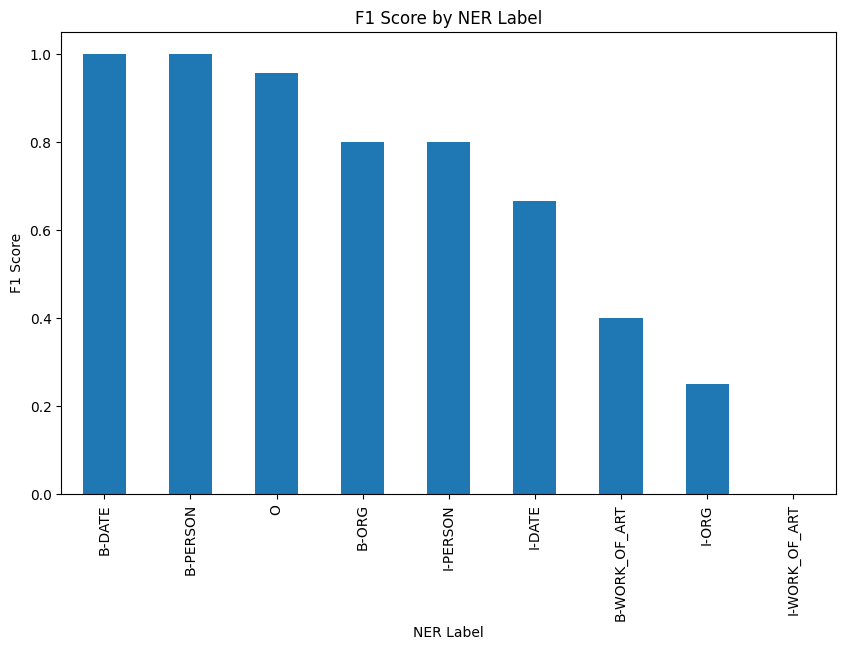

In [11]:
report_dict = classification_report(test_gold_labels, predicted, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.sort_values(by='f1-score', ascending=False)
report_df.drop('accuracy', inplace=True)
report_df.drop('macro avg', inplace=True)
report_df.drop('weighted avg', inplace=True)
report_df.drop('B-CARDINAL', inplace=True)
report_df.drop('B-GPE', inplace=True)
report_df.drop('I-EVENT', inplace=True)
report_df.drop('I-GPE', inplace=True)
report_df['f1-score'].plot(kind='bar', figsize=(10, 6))
plt.ylabel('F1 Score')
plt.xlabel('NER Label')
plt.title('F1 Score by NER Label')
plt.show()

## 2. Sentiment analysis
For sentiment analysis we used 2 models. 

- First we used vader, but this was not really that successful, getting an accuracy of 40%
- We also used a Naïve Bayes classifier

Reasoning for using VADER:
- Vader is a rule-based lexicon. (lecture 4, slide 36) This means that, at least on a dataset this small, it is very easy and very fast to use. However, these two properties often go at the cost of performance. For this reason, we wanted to see how it would compare against something that needed more effort and time.
- Lemmatizing helps the model generalize the words used in the test set to something in the VADER lexicon.
- After fine tuning the model using different sets of allowed POS-tagged words, it was found that allowing only verbs, adjectives and adverbs yielded the highest performance.

Reasoning for using Sklearn multinomialNB (Naïve Bayes):
- For sentiment analysis, finding similar training data to that of the providid test set is trivial; The set consists of tweet-like, short text with informal speech.
- Although more complicated, the group had experience in using the model, and could reuse parts of the previously implemented model from Lab3.
- Using the TF-IDF score of the words instead of a normal bag of words representation allows the model to prioritize more prevalent words for the determination of sentiment (very strongly polarizing words might not have a high TF-IDF score, and thus be not that important. They might just be part of normal speech as well). (Lecture 2, slide 57)
- Due to the very small test-set-size, we chose the min_df parameter as small as possible, at 1. This was also confirmed to work best by running the model for different values.

In [12]:
test_df = pd.read_csv('data/sentiment-topic-test.tsv', delimiter='\t')
train_df = ConllCorpusReader('data/CONLL2003', 'train.txt', ['words', 'pos', 'ignore', 'chunk'])
valid_df = ConllCorpusReader('data/CONLL2003', 'valid.txt', ['words', 'pos', 'ignore', 'chunk'])

In [13]:
vader_model = SentimentIntensityAnalyzer()
nlp = spacy.load("en_core_web_sm")

In [14]:
def run_vader(text, lemmatize=False, parts_of_speech=None,):

    # Run VADER on a sentence from spacy
    # Provide lemmas instead of direct text
    # Provide 

    doc = nlp(text)
    input_to_vader = []

    for sentence in doc.sents:
        for token in sentence:
            to_add = token.text

            if lemmatize:
                to_add = token.lemma_ if token.lemma_ != '-PRON-' else token.text

            if not parts_of_speech:
                input_to_vader.append(to_add)
                continue
            if token.pos_ in parts_of_speech:
                    input_to_vader.append(to_add)

    return vader_model.polarity_scores(' '.join(input_to_vader))

def vader_output_to_label(vader_output: dict):
    compound = vader_output['compound']
    
    if compound < 0:
        return 'negative'
    if compound == 0.0:
        return 'neutral'
    if compound > 0.0:
        return 'positive'
    
def test_vader(test_set, lemmatize=False, parts_of_speech=None):
    """
    Run VADER on a test set
    """ 
    texts = []
    vader_predictions = []
    gold_labels = []

    for index, row in test_set.iterrows():
        text = row['text']
        label = row['sentiment']
        vader_output = run_vader(text, lemmatize=lemmatize, parts_of_speech=parts_of_speech)
        vader_predictions.append(vader_output_to_label(vader_output))
        gold_labels.append(label)
        texts.append(text)
    
    return gold_labels, vader_predictions

In [15]:
#evaluation
gold_labels, vader_predictions = test_vader(test_df, lemmatize=True, parts_of_speech={'VERB', 'ADJ', 'ADV'})
print(classification_report(gold_labels, vader_predictions))

              precision    recall  f1-score   support

    negative       0.50      0.25      0.33         4
     neutral       0.40      0.67      0.50         3
    positive       0.33      0.33      0.33         3

    accuracy                           0.40        10
   macro avg       0.41      0.42      0.39        10
weighted avg       0.42      0.40      0.38        10



In [16]:
train_data = pd.read_csv('data/Kaggle/sentiment-emotion-labelled_Dell_tweets.csv', delimiter=',')
train_data = train_data[['Text', 'sentiment']]

#replace Text by text
train_data.columns = ['text', 'sentiment']

#remove nan values
train_data = train_data.dropna()

#reshape test set
test_df.head()
test_df = test_df[['text', 'sentiment']]

#add test set at the end of training set
all_data = pd.concat([train_data, test_df], ignore_index=True)


In [17]:
#append the text to the corresponding sentiment
train_dict = {'text': [], 'sentiment': []}

for index, row in all_data.iterrows():
    train_dict['text'].append(str(nlp(row['text'])))
    train_dict['sentiment'].append(row['sentiment'])

In [18]:
# We use a Naive Bayes classifier, and fit it to our data

count_vect = CountVectorizer(min_df=1,
                            tokenizer=nltk.word_tokenize, # use the nltk tokenizer
                            stop_words=stopwords.words('english')) # remove stopwords

X_counts = count_vect.fit_transform(train_dict['text'])

train_tfidf_transformer = TfidfTransformer()
X_train_tfidf = train_tfidf_transformer.fit_transform(X_counts)


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, train_dict['sentiment'], test_size=10, shuffle=False)

clf = MultinomialNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

    negative       0.57      1.00      0.73         4
     neutral       0.00      0.00      0.00         3
    positive       1.00      1.00      1.00         3

    accuracy                           0.70        10
   macro avg       0.52      0.67      0.58        10
weighted avg       0.53      0.70      0.59        10



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

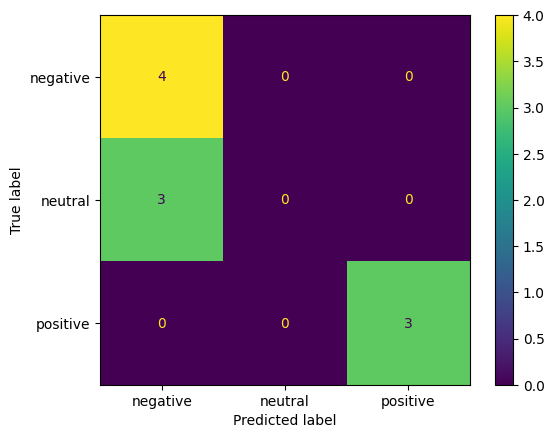

In [19]:
# Performance analysis
print(classification_report(y_test, y_pred))


confusion_matrix = confusion_matrix(y_test, y_pred)
diplay = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                               display_labels=clf.classes_)
diplay.plot()
plt.show()

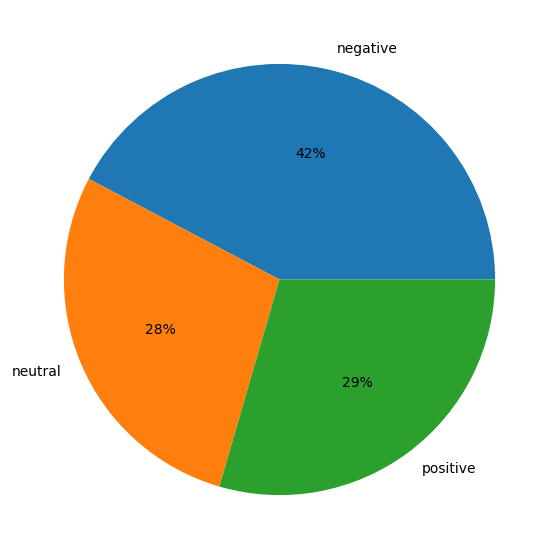

In [20]:
#distribution training data

fig = plt.figure(figsize=(10, 7))
plt.pie(clf.class_count_, labels=clf.classes_, autopct='%.0f%%')

plt.show()

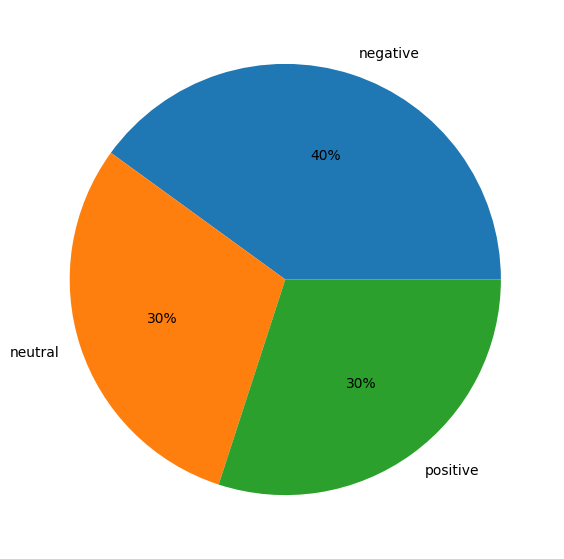

In [21]:
#distribution test data

data_t = []
for sent in clf.classes_:
    data_t.append(len([i for i in y_test if i==sent]))

fig = plt.figure(figsize=(10, 7))
plt.pie(data_t, labels=clf.classes_, autopct='%.0f%%')

plt.show()

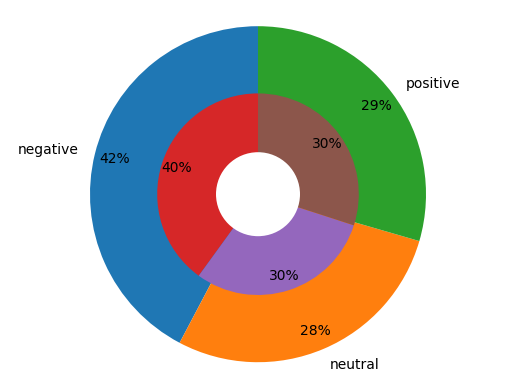

In [22]:
plt.pie(clf.class_count_, labels=clf.classes_, autopct='%.0f%%', startangle=90, pctdistance =0.88, radius= 1.0,) #outer circle train
plt.pie(data_t, autopct='%.0f%%',startangle=90, pctdistance =0.85, radius= 0.60) #inner circle test

centre_circle = plt.Circle((0,0), 0.25, fc='white')
fig= plt.gcf()
fig.gca().add_artist(centre_circle) 

# Plotting the pie 
plt.axis('equal')
plt.show()

## 3. Topic modelling
For topic modelling we used the bert classification model, trained on a supervised training dataset

Reasoning for using supervised model:
- Since we know exactly how many topics there are and what they are, the disadvantage of new topics not being detected is less of a problem (lecture 6, slide 16). Furthermore, this allows us to exactly set the right amount of topics for the model. Lastly, supervised models allow for easily interpretable results and often yield a high performance.

Reasoning for using BERT:
- The group was most familiar with model, having used it before.
- Very 'general' model with a lot of options that forms the basis for a lot of other models (lecture 3, slide 64)
- We did manual hyperparameter selection, and found that, from the parameters used, the ones listed above as the final values performed best. It is very possible that there is better configurations however.

An important note to make is that it was very difficult to find an existing dataset with the right labels. For this reason, the group decided it would be best to create a dataset from scratch. We used multiple machine implementations to make this easier, but this also means that the data labels are not gold labels, but silver: the are created by machine and validated by us. (Lecture 2, slide 51)

In [32]:
#Read data
train_topic_data = pd.read_csv('data/own_dataset.tsv', sep='\t')
test_topic_data = pd.read_csv('data/sentiment-topic-test.tsv', sep='\t')

#remove sentiment column and sentence id column
train_topic_data = train_topic_data.drop(columns=['sentiment'])
train_topic_data = train_topic_data.drop(columns=['sentence id'])
test_topic_data = test_topic_data.drop(columns=['sentiment'])
test_topic_data = test_topic_data.drop(columns=['sentence id'])

#change each value in topic to an integer
train_topic_data['topic'] = train_topic_data['topic'].astype('category')
train_topic_data['topic'] = train_topic_data['topic'].cat.codes
test_topic_data['topic'] = test_topic_data['topic'].astype('category')
test_topic_data['topic'] = test_topic_data['topic'].cat.codes

#change topic header to labels
train_topic_data = train_topic_data.rename(columns={"topic": "labels"})
test_topic_data = test_topic_data.rename(columns={"topic": "labels"})

In [33]:
all_data = pd.concat([train_topic_data, test_topic_data])

train, test = train_test_split(train_topic_data, test_size=10, shuffle=False)
train, dev = train_test_split(train, test_size=0.3, shuffle=True)

In [34]:
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in same directory
model_args.evaluate_during_training=True # perform evaluation while training the model
# (eval data should be passed to the training method)

model_args.num_train_epochs=15
model_args.train_batch_size=64
model_args.learning_rate=4e-5
model_args.max_seq_length=256
# Note! Increasing max_seq_len may provide better performance, but training time will increase. 
# For educational purposes, we set max_seq_len to 256.

# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=32 # how often you want to run validation in terms of training steps (or batches)

In [35]:
bert_model = ClassificationModel('bert', 'bert-base-cased', num_labels=3, args=model_args, use_cuda=False)
_, history = bert_model.train_model(train, eval_df=dev, multi_label=False) 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
1it [00:05,  5.59s/it]
Epochs 1/15. Running Loss:    1.2538: 100%|██████████| 1/1 [00:17<00:00, 17.56s/it]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
def evaluate_model(model: ClassificationModel, dev: pd.DataFrame, test:pd.DataFrame):
    result, outputs, wrong_pred = model.eval_model(dev)
    
    predicted, probabilities = model.predict(test.text.to_list())
    test['predicted'] = predicted
    
    print(classification_report(test['labels'], test['predicted']))

evaluate_model(bert_model, dev, test)